In [1]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.tree import export_graphviz
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from xgboost.sklearn import XGBRegressor

import matplotlib.font_manager as fm
chinese_font = fm.FontProperties(fname=r"C:\Windows\Fonts\simsun.ttc", size=20)
plt.rcParams.update({'font.family': 'serif', 'font.serif': ['Times New Roman']})
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_excel("10.23.xlsx")


mean_A = data['active mass-mg'].mean()

# 使用均值填充A列的缺失值
data['active mass-mg'].fillna(mean_A, inplace=True)


data_DOI = data['DOI']
data_numeric = data.iloc[:, 1:14]
data_category = data.iloc[:, 14:-1]
data_target = data.iloc[:, -1]


#scaler = StandardScaler()
#data_numeric = scaler.fit_transform(data_numeric)
#data_numeric = pd.DataFrame(data_numeric,columns=['r-time','r-temperature', 'c-time', 'c-temperature', 'Co-mmol', 'CO(NH2)2','NH4F', 'SDS', 'DI-ml', 'active mass-mg', 'KOH', 'potential windows', 'current density'])

data_category['morphology'] = data_category['morphology'].astype('category')
data_category_encoded = pd.get_dummies(data_category)


#data_new1 = pd.concat([data_numeric_scaler,data_category_encoded],axis=1)
data_new1 = pd.concat([data_numeric,data_category_encoded],axis=1)
data_new1 = pd.concat([data_new1,data_target],axis=1)
data_new1

,r-time,r-temperature,c-time,c-temperature,Co-mmol,CO(NH2)2,NH4F,SDS,DI-ml,active mass-mg,...,F-base_NF,F-base_SSF,reference_0,reference_Ag-AgCl,reference_Hg/Hg2Cl2,reference_Hg/HgO,count_Pt,count_SELF,count_carbon,capacitance
0,12,60,2.0,350,3.312373,7.492507,2.241002,0.0,60,3.7,...,1,0,0,1,0,0,1,0,0,1287.000000
1,12,60,2.0,350,3.312373,7.492507,2.241002,0.0,60,3.7,...,1,0,0,1,0,0,1,0,0,1071.000000
2,12,60,2.0,350,3.312373,7.492507,2.241002,0.0,60,3.7,...,1,0,0,1,0,0,1,0,0,926.000000
3,12,60,2.0,350,3.312373,7.492507,2.241002,0.0,60,3.7,...,1,0,0,1,0,0,1,0,0,661.000000
4,12,60,2.0,350,3.312373,7.492507,2.241002,0.0,60,3.7,...,1,0,0,1,0,0,1,0,0,459.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
319,6,150,3.0,400,2.000000,5.000000,0.000000,0.0,40,2.2,...,0,1,1,0,0,0,0,0,1,68.911765
320,6,150,3.0,400,2.000000,5.000000,0.000000,0.0,40,2.2,...,0,1,1,0,0,0,0,0,1,63.241176
321,6,150,3.0,400,2.000000,5.000000,0.000000,0.0,40,2.2,...,0,1,1,0,0,0,0,0,1,60.229412
322,6,150,3.0,400,2.000000,5.000000,0.000000,0.0,40,2.2,...,0,1,1,0,0,0,0,0,1,57.229412


分位差为：841.463，下限为：-1166.956，上限为：2198.894,Q1：95.237,Q2：936.700
------
异常值共19条
39     5701.2
40     5087.3
41     4093.5
42     3548.8
43     3254.0
89     2368.0
90     2206.8
97     2353.8
147    3757.2
148    3441.6
149    3416.0
150    3318.4
151    3088.0
201    2295.0
254    2757.0
255    2254.4
264    2403.0
265    2234.0
278    2382.0
Name: capacitance, dtype: float64


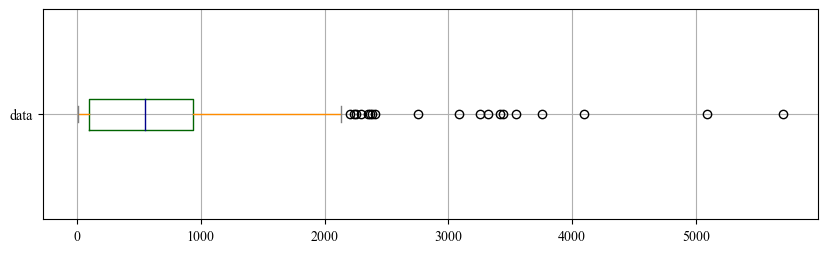

In [3]:
#处理异常值
# 箱型图
fig = plt.figure(figsize = (10,6))
ax1 = fig.add_subplot(2,1,1)
color = dict(boxes='DarkGreen', whiskers='DarkOrange', medians='DarkBlue', caps='Gray')
data_target.plot.box(vert=False, grid = True,color = color,ax = ax1,label = 'data')

# 基本统计量查看
s = data_target.describe()

# 计算分位差
q1 = s['25%']
q3 = s['75%']
iqr = q3 - q1
mi = q1 - 1.5*iqr
ma = q3 + 1.5*iqr
print('分位差为：%.3f，下限为：%.3f，上限为：%.3f,Q1：%.3f,Q2：%.3f' % (iqr,mi,ma,q1,q3))
print('------')

# 筛选出异常值error、剔除异常值之后的数据data_c
error2 = data_target[(data_target < mi) | (data_target > ma)]
data_c2 = data_target[(data_target >= mi) & (data_target <= ma)]
print('异常值共%i条' % len(error2))
print(error2)
data_new= data_new1.loc[data_c2.index]

In [4]:
#划分数据集
random_seed=44
np.random.seed(random_seed)
seed=np.random.randint(low=1,high=230)

X = data_new.iloc[:,0:-1]
y = data_new.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
param_test1 = {'n_estimators':[10,100,500,1000,2000,50,250,750,1500],
                'learning_rate':[0.01,0.015,0.025,0.05,0.1],
                'max_depth':[int(x) for x in np.linspace(start=0,stop=200,num=100)],
                'gamma':[0,0.05,0.06,0.07,0.08,0.09,0.1,0.3,0.5,0.7,0.9,1],
                'reg_alpha':[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.5,1],
                'reg_lambda':[0,0.1,0.5,1],
                'min_child_weight':[1,3,5,7],
                'colsample_bytree':[0.6, 0.7, 0.8, 0.9,1],
                'subsample':[0.6, 0.7, 0.8, 0.9, 1]
              }
scoring = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']
rsearch=RandomizedSearchCV(estimator=XGBRegressor(random_state=seed),
                            param_distributions=param_test1,
                            n_iter=100,#随机搭配超参数组合的次数
                            scoring=scoring,
                            n_jobs=-1,
                            cv=5,
                            verbose=1,
                            random_state=seed,
                            refit='neg_mean_absolute_error'
                           )
rsearch.fit(X_train,y_train)
#rsearch.cv_results_, 
rsearch.best_params_, rsearch.best_score_

#subsample': 0.7,
#  'reg_lambda': 100,
#  'reg_alpha': 100,
#  'n_estimators': 2000,
# 'min_child_weight': 3,
#  'max_depth': 38,
#  'learning_rate': 0.3,
#  'gamma': 0.4,
#  'colsample_bytree': 0.7

Fitting 5 folds for each of 100 candidates, totalling 500 fits


KeyboardInterrupt: 

In [5]:
param_test2 = {'n_estimators':range(730,760,1),#[490],
                'learning_rate':[0.03],
                'max_depth':[14],
                'gamma':[0],
                'reg_alpha':[0.07],
                'reg_lambda':[0.1],
                'min_child_weight':[1],
                'colsample_bytree':[0.7],
                'subsample':[0.3]
              }
scoring = ['neg_mean_absolute_error', 'r2', 'neg_root_mean_squared_error']
gsearch = GridSearchCV(estimator = XGBRegressor(random_state=seed), 
                        param_grid = param_test2,
                        scoring=scoring,
                        cv=10,
                        verbose=1,
                        n_jobs=-1,
                        refit='neg_mean_absolute_error'
                       )
gsearch.fit(X_train,y_train)
#gsearch.cv_results_, 
gsearch.best_params_, gsearch.best_score_


Fitting 10 folds for each of 30 candidates, totalling 300 fits


({'colsample_bytree': 0.7,
  'gamma': 0,
  'learning_rate': 0.03,
  'max_depth': 14,
  'min_child_weight': 1,
  'n_estimators': 743,
  'reg_alpha': 0.07,
  'reg_lambda': 0.1,
  'subsample': 0.3},
 -71.09183461306606)

In [7]:
ScoreAll = []
for i in range(1,200,1):
    DT = XGBRegressor(random_state=seed,learning_rate=0.03,max_depth=i,gamma=0,reg_alpha=0.07,reg_lambda=0.1,min_child_weight=1,
                colsample_bytree=0.7,subsample=0.3,n_estimators=743)
    scores = (-cross_val_score(DT,X_train,y_train,cv=10,scoring='neg_mean_absolute_error')).mean()
    ScoreAll.append([i,scores])
ScoreAll = np.array(ScoreAll)

min_score = np.where(ScoreAll==np.min(ScoreAll[:,1]))[0][0] ##这句话看似很长的，其实就是找出最高得分对应的索引
print("最优参数以及得分:",ScoreAll[min_score])  

# print(ScoreAll[,0])
plt.figure(figsize=[20,5])
plt.plot(ScoreAll[:,0],ScoreAll[:,1])
plt.show()

Exception ignored in: <function ZipFile.__del__ at 0x00000184824B2EF0>
Traceback (most recent call last):
  File "D:\jupyter\lib\zipfile.py", line 1819, in __del__
    self.close()
  File "D:\jupyter\lib\zipfile.py", line 1821, in close
    def close(self):
KeyboardInterrupt: 

KeyboardInterrupt



In [6]:
model = gsearch.best_estimator_
clf=model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='rmse',
          early_stopping_rounds=10, verbose=False)

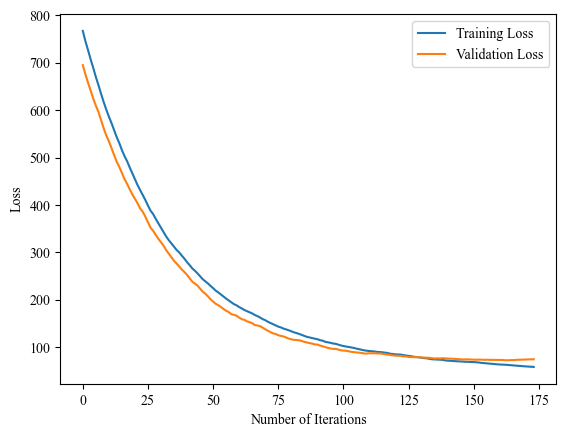

In [7]:
eval_results = model.evals_result()
train_loss = eval_results['validation_0']['rmse']
val_loss = eval_results['validation_1']['rmse']

# 绘制损失函数曲线
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Number of Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
y_pred = clf.predict(X_test)
error = y_pred-y_test

RMSE is 72.6428028997692, and MAE is 46.82811359752307, and R is 0.9879474599039508.


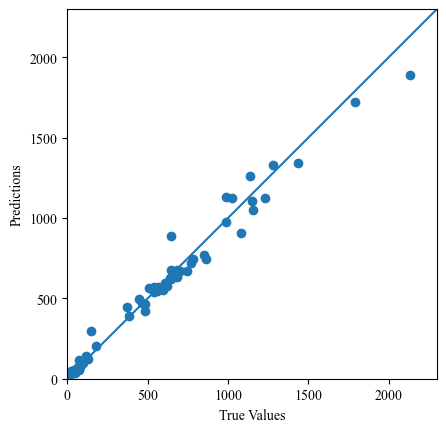

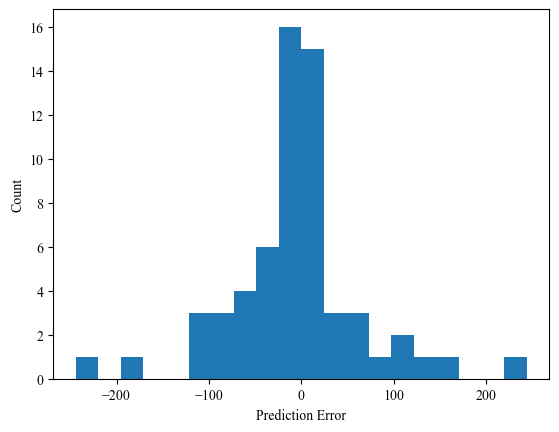

In [9]:
plt.figure(1)
plt.clf()
ax=plt.axes(aspect='equal')
plt.scatter(y_test,y_pred)
plt.xlabel('True Values')
plt.ylabel('Predictions')
Lims=[0,2300]
plt.xlim(Lims)
plt.ylim(Lims)
plt.plot(Lims,Lims)
plt.grid(False)
    
plt.figure(2)
plt.clf()
plt.hist(error,bins=20)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.grid(False)

# Verify the accuracy
R2 = metrics.r2_score(y_test,y_pred)
RMSE = metrics.mean_squared_error(y_test,y_pred)**0.5
MAE = metrics.mean_absolute_error(y_test, y_pred)
r = math.sqrt(R2)
print('RMSE is {0}, and MAE is {1}, and R is {2}.'.format(RMSE, MAE, r))



In [12]:
y_prediction_test=model.predict(X_test)
y_prediction_train=model.predict(X_train)
MAE1 = metrics.mean_absolute_error(y_test, y_prediction_test)
print(MAE1,'\n')
MAE2 = metrics.mean_absolute_error(y_train, y_prediction_train)
print(MAE2)

46.82811359752307 

34.11451672743548


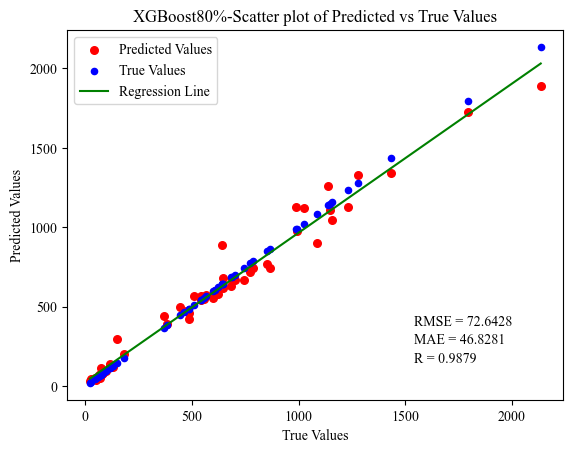

In [13]:
plt.scatter(y_test, y_pred, c='red', label='Predicted Values', s=30)
plt.scatter(y_test, y_test, c='blue', label='True Values', s=20)

X_r = np.array(y_test).reshape(-1, 1)
y_r = np.array(y_pred)

model_linear = LinearRegression()
model_linear.fit(X_r, y_r)

X_line = np.linspace(min(y_test), max(y_test), 100).reshape(-1, 1)
y_line = model_linear.predict(X_line)

plt.plot(X_line, y_line, color='green', label='Regression Line')

plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.title('XGBoost80%-Scatter plot of Predicted vs True Values')
plt.text(0.7, 0.1, f'R = {r:.4f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.15, f'MAE = {MAE:.4f}', transform=plt.gca().transAxes)
plt.text(0.7, 0.2, f'RMSE = {RMSE:.4f}', transform=plt.gca().transAxes)
plt.legend()
plt.show()

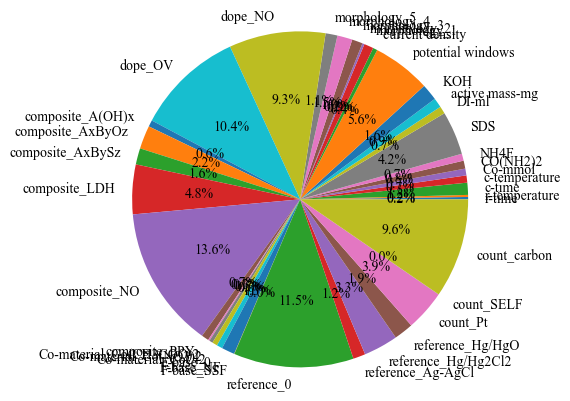

array([0.00226864, 0.00195569, 0.01164629, 0.00692224, 0.00652894,
       0.00769876, 0.00673002, 0.04187475, 0.00722116, 0.00918688,
       0.01591446, 0.0562284 , 0.00428209, 0.00906493, 0.0020211 ,
       0.01025955, 0.01453546, 0.01140924, 0.09278101, 0.1037114 ,
       0.00629733, 0.02243595, 0.01564462, 0.04770916, 0.13644393,
       0.00701534, 0.00144838, 0.00338219, 0.00498695, 0.00553902,
       0.01259302, 0.0002333 , 0.11541494, 0.0118133 , 0.03315153,
       0.01863597, 0.03916258, 0.00015005, 0.09570153], dtype=float32)

In [9]:
RF_features=clf.feature_importances_

feature_labels = ['r-time', 'r-temperature', 'c-time', 'c-temperature', 'Co-mmol',
                 'CO(NH2)2', 'NH4F', 'SDS', 'DI-ml', 'active mass-mg',
                 'KOH', 'potential windows', 'current density',
                 'morphology_1','morphology_2','morphology_3','morphology_4','morphology_5',
                'dope_NO','dope_OV',
                'composite_A(OH)x','composite_AxByOz','composite_AxBySz','composite_LDH','composite_NO','composite_PPY',
                'Co-material_Co(CH3COO)2','Co-material_Co(NO3)2','Co-material_CoCl2',
                'F-base_0','F-base_NF','F-base_SSF',
                'reference_0','reference_Ag-AgCl','reference_Hg/Hg2Cl2','reference_Hg/HgO',
                'count_Pt','count_SELF','count_carbon']

# 创建饼图
fig, ax = plt.subplots()
ax.pie(RF_features, labels=feature_labels, autopct='%1.1f%%')
ax.axis('equal')  # 使饼图比例相等

plt.show()
RF_features

In [77]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error
MAE_score = 0
R2_score=0
RMSE_score=0
r_score=0

MAE_sum_score = 0
R2_sum_score = 0
RMSE_sum_score = 0
r_sum_score = 0
i=1
column_names = ['r-time','r-temperature','c-time','c-temperature','Co-mmol','CO(NH2)2','NH4F','SDS','DI-ml',
                'active mass-mg','KOH','potential windows','current density',
                'morphology_1','morphology_2','morphology_3','morphology_4','morphology_5',
                'dope_NO','dope_OV',
                'composite_A(OH)x','composite_AxByOz','composite_AxBySz','composite_LDH','composite_NO','composite_PPY',
                'Co-material_Co(CH3COO)2','Co-material_Co(NO3)2','Co-material_CoCl2',
                'F-base_0','F-base_NF','F-base_SSF',
                'reference_0','reference_Ag-AgCl','reference_Hg/Hg2Cl2','reference_Hg/HgO',
                'count_Pt','count_SELF','count_carbon']
target = data_new['capacitance']
data_data = data_new[column_names]
KF = KFold(n_splits=10, shuffle=True, random_state=seed)
for train_index, test_index in KF.split(X):
    #print("TRAIN", train_index, "TEST", test_index)
    x_train, x_test = data_data.iloc[train_index], data_data.iloc[test_index]
    Y_train, Y_test = target.iloc[train_index], target.iloc[test_index]
    clt = model.fit(x_train, Y_train)
    Y_pred = clt.predict(x_test)
    
    MAE_score = metrics.mean_absolute_error(Y_test, Y_pred)
    R2_score=metrics.r2_score(Y_test,Y_pred)
    RMSE_score=metrics.mean_squared_error(Y_test,Y_pred)**0.5
    r_score=math.sqrt(R2_score)
    
    MAE_sum_score = MAE_sum_score+MAE_score
    R2_sum_score = R2_sum_score+R2_score
    RMSE_sum_score = RMSE_sum_score+RMSE_score
    r_sum_score = r_sum_score+r_score
    
    print("第{0}次".format(i))
    print("R2:", R2_score)
    print("MAE:", MAE_score)
    print("RMSE:", RMSE_score)
    print("r:", r_score)
    i+=1
# 计算平均准确率
R2_avg_score = R2_sum_score/10
print("平均R2为：", R2_avg_score)
MAE_avg_score = MAE_sum_score/10
print("平均MAE为：", MAE_avg_score)
RMSE_avg_score = RMSE_sum_score/10
print("平均RMSE为：", RMSE_avg_score)
r_avg_score = r_sum_score/10
print("平均r为：", r_avg_score)

第1次
R2: 0.9724758950336542
MAE: 41.74698849098794
RMSE: 73.89858891158057
r: 0.986141924386979
第2次
R2: 0.9510336871374248
MAE: 59.24908141696331
RMSE: 110.0273764195207
r: 0.975209560626548
第3次
R2: 0.9865263489756773
MAE: 28.333467251480062
RMSE: 56.5803521510606
r: 0.9932403279044187
第4次
R2: 0.9566129438597866
MAE: 48.33110294733578
RMSE: 107.55563182543317
r: 0.9780659199971066
第5次
R2: 0.8756135809057416
MAE: 74.61048677737618
RMSE: 145.99855559800653
r: 0.9357422620068742
第6次
R2: 0.9640057800043803
MAE: 66.98392373426034
RMSE: 97.69782605966158
r: 0.9818379601565527
第7次
R2: 0.7869199383628803
MAE: 106.3057922173793
RMSE: 245.80870857616887
r: 0.887085079551494
第8次
R2: 0.9813850448233081
MAE: 48.93926185261119
RMSE: 68.83348731497942
r: 0.9906487999403765
第9次
R2: 0.9595394196269309
MAE: 55.545535531409506
RMSE: 102.05995606663372
r: 0.9795608299778686
第10次
R2: 0.9503753498587787
MAE: 89.14589535906426
RMSE: 144.69842075507705
r: 0.974871965880022
平均R2为： 0.9384487988588562
平均MAE为： 61.

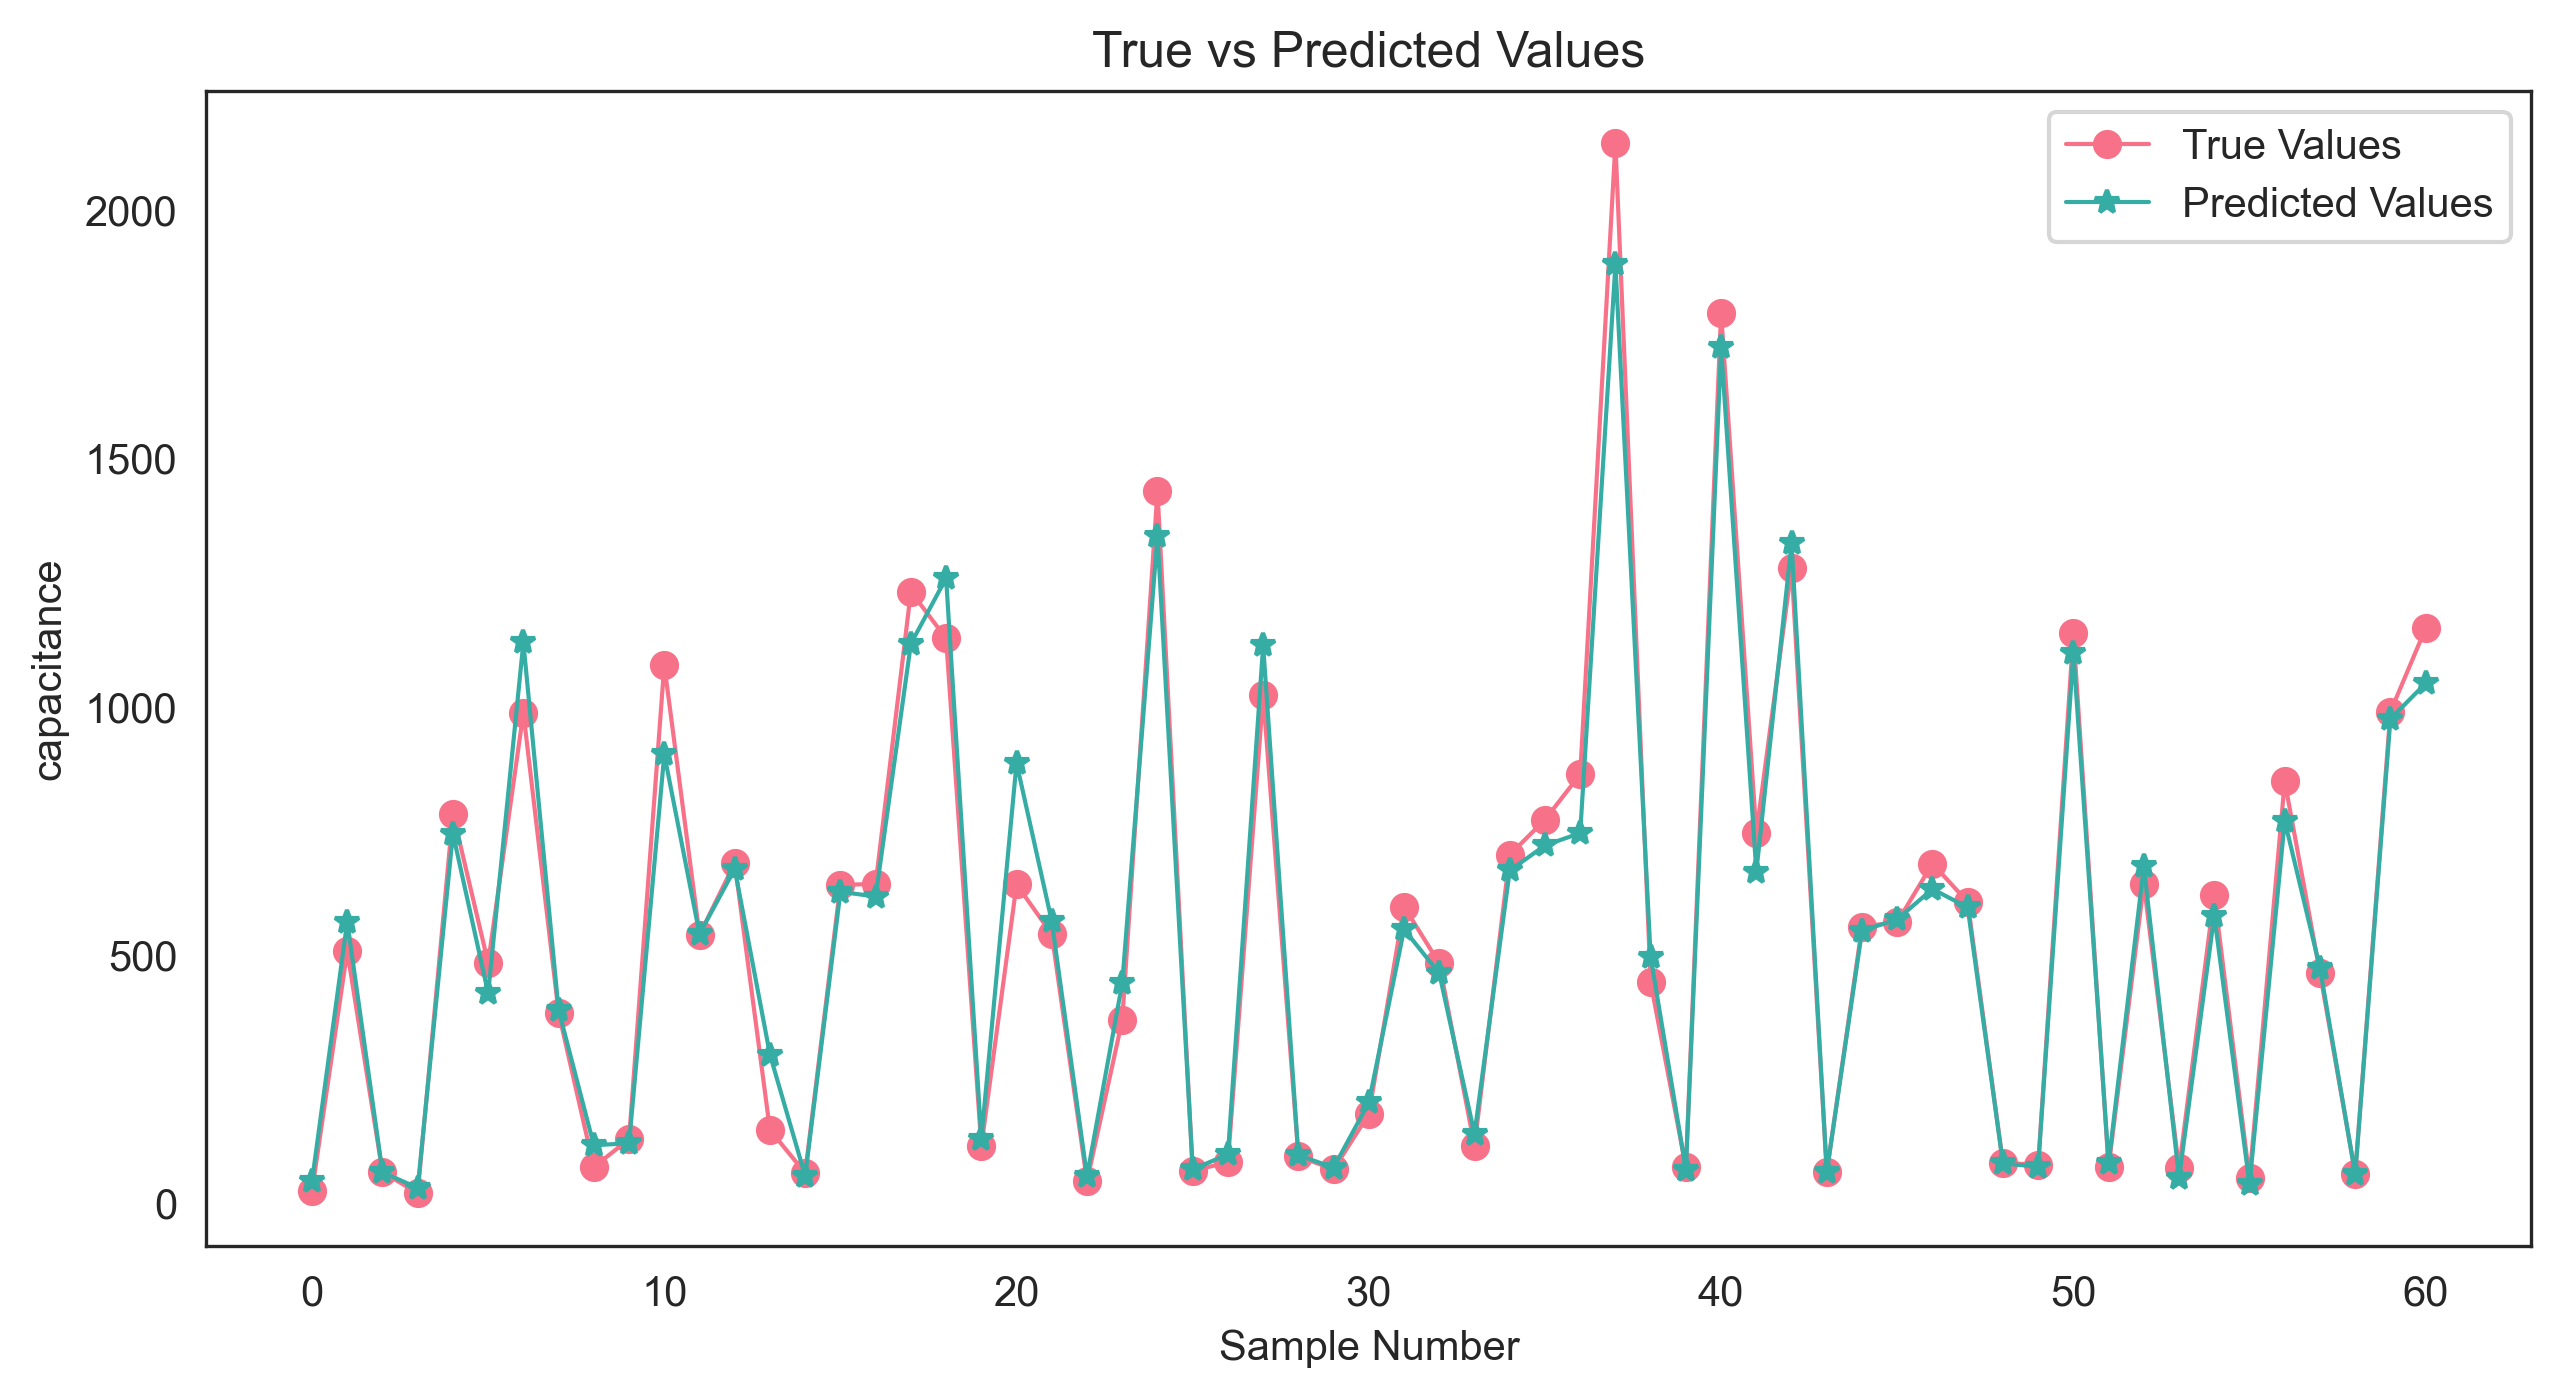

In [19]:

sns.set_style("white") 
palette = sns.color_palette("husl", n_colors=2) 
 
# 设置画布大小和分辨率
plt.figure(figsize=(10, 5), dpi=300)
 
# 绘制测试集数据的真实值和模型预测值的折线图
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="True Values", color=palette[0], linewidth=1,marker='o')
plt.plot(x_ax, y_pred, label="Predicted Values", color=palette[1], linewidth=1,marker='*')


# 添加标题和标签
plt.title("True vs Predicted Values")
plt.xlabel("Sample Number")
plt.ylabel("capacitance")
 
# 显示图例
plt.legend()
# 显示图形
plt.show()


In [20]:
for item in y_test:
    print(item)
print('///')
for item in y_pred:
    print(item)

24.7
508.0
63.3
20.8
785.0
484.4
988.0
384.0
73.33
129.7
1084.0
541.0
685.3
148.0
61.3
641.4
643.3
1232.0
1137.5
115.33
642.4
542.0
44.8
369.0
1434.4
66.0
83.0
1023.0
95.2
68.5
180.26
597.5999999999999
483.4
116.0
702.0
772.690909090909
864.0
2134.6
445.0
73.0
1792.8
745.0
1280.0
63.2
557.4
566.2545454545455
684.327272727273
607.0
81.87058823529412
77.9
1148.0
73.0
644.0
70.5
621.6181818181817
50.8
850.0
464.4
60.22941176470589
990.0
1158.0
///
45.18743
567.38666
62.93884
31.35147
744.59033
423.26404
1129.5275
389.4585
117.273674
121.283676
904.0089
542.46857
673.64404
299.5715
55.271828
627.4451
617.99146
1126.9435
1259.0029
130.6812
886.6749
567.92993
54.838543
443.59622
1344.5525
68.65895
99.131805
1123.3856
97.219635
72.19997
203.43738
551.9155
463.371
140.01648
670.4179
720.85516
745.7552
1890.4894
496.4795
68.01035
1723.2994
668.3508
1329.0242
63.220432
548.9826
572.15216
633.07043
596.04346
80.66087
74.10313
1108.8569
81.58772
678.623
51.928257
579.48
38.529667
770.14526
474.210

In [11]:
TEST = pd.read_excel("new1023.xlsx")
#mean_mass = data_new['active mass-mg'].mean()
# 将均值填充到test中的mass列
#TEST['active mass-mg'].fillna(mean_mass, inplace=True)

TEST_pred=clf.predict(TEST)
TEST_pred

array([ 617.8458 ,  815.88995,  730.3193 ,  937.3121 , 1120.7155 ,
       1041.6055 , 1058.9796 ,  136.90862,  870.7823 ,  928.62317],
      dtype=float32)

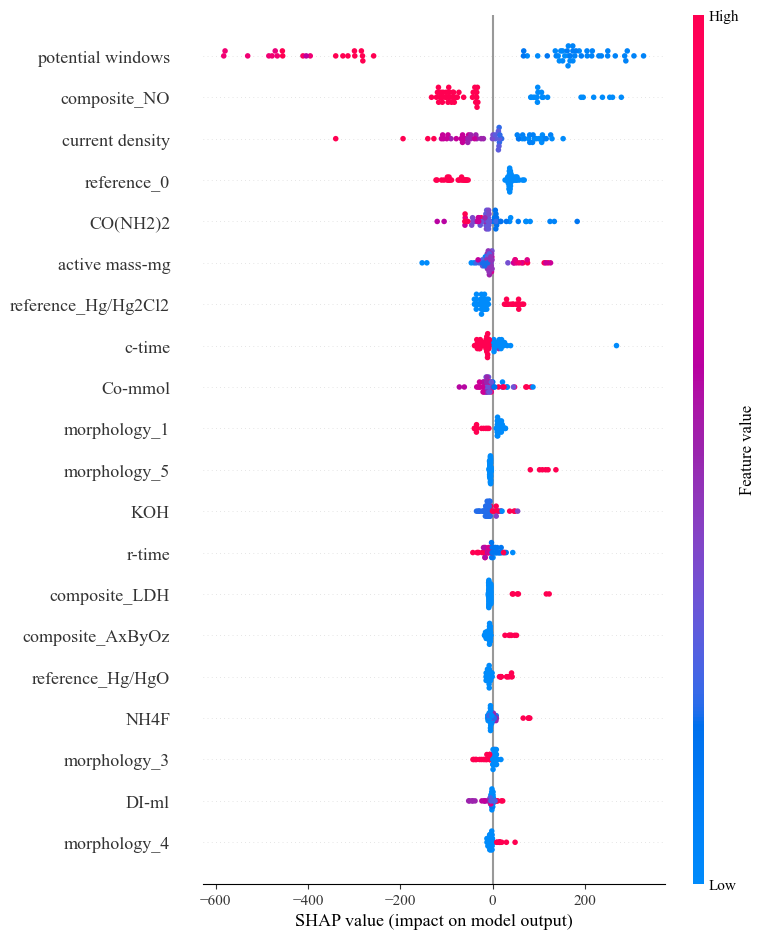

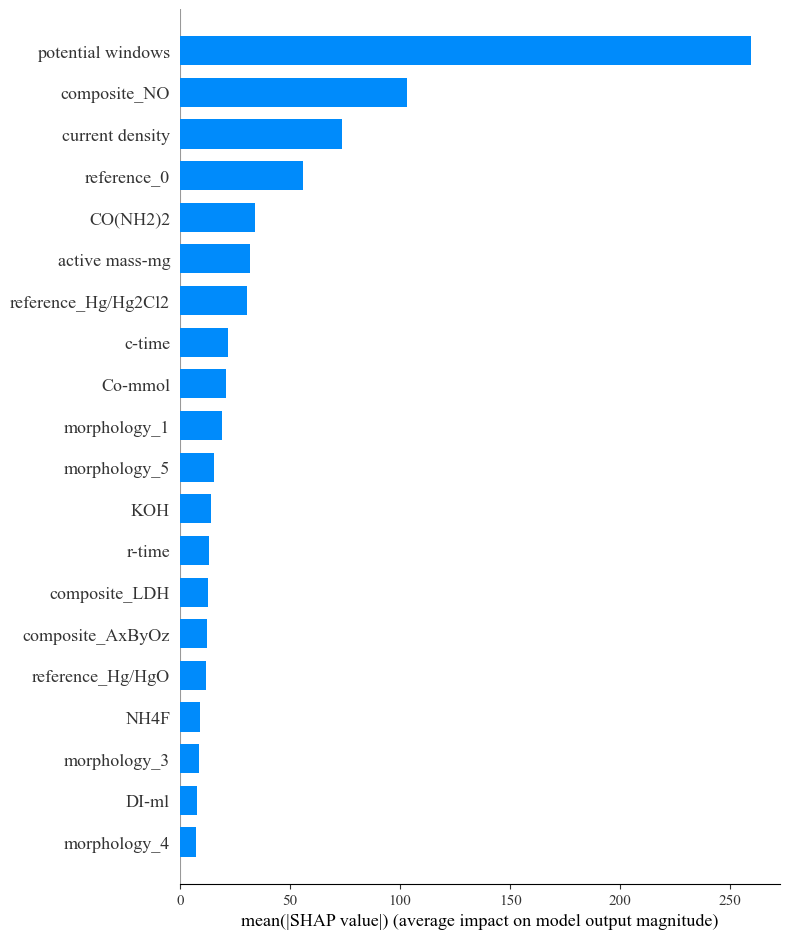

In [12]:
import shap
explainer = shap.Explainer(clf, X_train)

# 使用SHAP解释模型
shap_values = explainer.shap_values(X_test)

# 可视化SHAP值
shap.summary_plot(shap_values, X_test)
shap.summary_plot(shap_values, X, plot_type="bar")